# Model building

There are several top notch deep learning frameworks that would suffice for this task; but in this case we'll be using __Tensorflow__ from __Google__.  

In [85]:
# Import necessary packages.
%matplotlib inline
import numpy as np
import absl.logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.xception import Xception

# Ignoring all unnecessary warnings.
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")

# Important constants.
DATASET_PATH = r"C:\Users\ifunanyaScript\Everything\BrainTumour_DiagnosisApp\data\clean_dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 70

In [4]:
# Load the dataset with the Tensorflow data pipeline.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\ifunanyaScript\Everything\BrainTumour_DiagnosisApp\data\clean_dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = (BATCH_SIZE),
)

Found 3000 files belonging to 2 classes.


In [5]:
len(dataset)

375

The dataset is loaded as batches specified by the "batch_size" parameter. In this case, 3000 images batched into sizes of 8. Thus, 375 batches and that would be the length of the dataset.

The target/label_names of this dataset are the names of the sub directories in the _DATASET_PATH_ specified earlier.

In [6]:
# Gets the label names from the dataset object.
label_names = dataset.class_names
label_names

['no_tumour', 'tumour']

When one wants to train a model with a particular dataset, the normal practice is to split said dataset into separate chunks; particularly a training chunk and a testing chunk. The purpose of splitting the data is for evaluation purposes after training the model.  
Most times, ML folks use __scikit-learn's__ ___train_test_split___. In this case, we'll use the ___take___ and ___skip___ attributes of the dataset object which allows us to grab a portion of the dataset by batches.  

The training chunk is always a lot larger that the validation chunk and testing chunk, so that the model is trained on as much data as possible. We'll set aside for training, validation and testing; 80%, 10%, 10% respectively.

In [7]:
train_size = 0.8
print(f"The training dataset should be {int(len(dataset)*train_size)} batches")

The training dataset should be 300 batches


In [8]:
# Takes first 300 batches of the dataset
train_ds = dataset.take(300)
len(train_ds)

300

In [9]:
# Remaining data after the training chunk.
remnant = dataset.skip(300)
len(remnant)

75

In [10]:
val_size = 0.1
print(f"The validation dataset should be {int(len(dataset)*val_size)} batches")

The validation dataset should be 37 batches


In [11]:
# Takes the first 37 batch of the remaining data.
val_ds = remnant.take(37)
len(val_ds)

37

In [12]:
# Takes all the data after the first 37 batches.
test_ds = remnant.skip(37)
len(test_ds)

38

All of these snippets can be wrapped in a simple function.

In [13]:
def chunking(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, buffer=1000):
    """
    The purpose of this function is to split a dataset into the necessary chunks and return
    said chunks accordingly.
    
    A dataset is passed as an argument and the partitions are made with the predefined split sizes.
    One can also alter the split sizes by changing the values while calling the function.
    """
    
    number_of_batches = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(buffer, seed=321)
    
    train_size = int(train_split*number_of_batches)
    validation_size = int(validation_split*number_of_batches)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(validation_size)
    test_ds = dataset.skip(train_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = chunking(dataset)
print(f"""The dataset of 375 batches was chunked as follows: 
{len(train_ds)} batches for the Training dataset, 
{len(val_ds)} batches for the Validation dataset and, 
{len(test_ds)} batches for the Testing dataset.""")

The dataset of 375 batches was chunked as follows: 
300 batches for the Training dataset, 
37 batches for the Validation dataset and, 
38 batches for the Testing dataset.


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Caching is used to improve data retrieval performance by reducing the need to access underlying storage.  
In short, the dataset is cached in memory. This reduces training time because there will be no need open files and read images during each epoch.. The next epochs will reuse the data cached by the cache transformation.

In [16]:
# Layers for data_augmentation, resizing and rescaling.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4)
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

As always, feature engineering/extraction is an essential step to training a reliably accurate model. However, one might ask how do you extract features when training a CNN. Well, the convolution filters in CNN hovers through the entire image and extracts features from the image. This is actually a rather simple mathematical process if you consider it.   
We'll stack several convolutional layers together to grab enough features as possible. Also reducing dimensionality is very important so as to keep the trainable parameters(weights) concise and reduce training time, hence, we use Maxpooling.  
After the convolutional layers we'll add a fully connected dense layer containing an arbitrary number of neurons and a final output layer activated by a softmax function since we are handling this as a multiclass task.

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_labels = len(label_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu")
    layers.Dense(n_labels, activation="softmax")
])

# Initialises the model.
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (8, 224, 224, 3)          0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                  

Yowza!!!<br> 
We have to train over 155,900 weights.<br>
This will take a pretty long time using a CPU.<br>
Patience is a virtue.

As we know, backward propagation is one of two fundamental steps in training an __NN__. We'll use Adam optimizer for backward propagation.<br>
Since it is binary classification __i.e__, no tumour[0] or tumour[1], we'll use BinaryCrossentropy to calculate the loss of the model's prediction compared to the actual labels.<br>
Then we can track our model's performance with an accuracy metric.


__NB:__ Backward propagation is a method sort of differencial calculus where we calculate the gradient of the loss function with respect to the parameters(weights and biases). Then we update said weights and biases according to minimise the loss.

In [19]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

We train the model by fitting it to the training dataset and we validate its performance with the validation dataset.

In [20]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/70
300/300 [==============================] - 975s 3s/step - loss: 0.6959 - accuracy: 0.5058 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 2/70
300/300 [==============================] - 882s 3s/step - loss: 0.6850 - accuracy: 0.5412 - val_loss: 0.6431 - val_accuracy: 0.6892
Epoch 3/70
300/300 [==============================] - 772s 3s/step - loss: 0.6752 - accuracy: 0.5746 - val_loss: 0.6317 - val_accuracy: 0.6689
Epoch 4/70
300/300 [==============================] - 825s 3s/step - loss: 0.6615 - accuracy: 0.6150 - val_loss: 0.6413 - val_accuracy: 0.6014
Epoch 5/70
300/300 [==============================] - 1591s 5s/step - loss: 0.6526 - accuracy: 0.6325 - val_loss: 0.6062 - val_accuracy: 0.7061
Epoch 6/70
300/300 [==============================] - 793s 3s/step - loss: 0.6339 - accuracy: 0.6475 - val_loss: 0.6042 - val_accuracy: 0.6520
Epoch 7/70
300/300 [==============================] - 29428s 98s/step - loss: 0.6217 - accuracy: 0.6833 - val_loss: 0.6547 - val_accuracy: 0.

300/300 [==============================] - 191s 637ms/step - loss: 0.2081 - accuracy: 0.9204 - val_loss: 0.2396 - val_accuracy: 0.8953
Epoch 58/70
300/300 [==============================] - 212s 708ms/step - loss: 0.2135 - accuracy: 0.9171 - val_loss: 0.1656 - val_accuracy: 0.9257
Epoch 59/70
300/300 [==============================] - 192s 640ms/step - loss: 0.2321 - accuracy: 0.9033 - val_loss: 0.1487 - val_accuracy: 0.9392
Epoch 60/70
300/300 [==============================] - 188s 626ms/step - loss: 0.2264 - accuracy: 0.9125 - val_loss: 0.1602 - val_accuracy: 0.9426
Epoch 61/70
300/300 [==============================] - 188s 625ms/step - loss: 0.2080 - accuracy: 0.9208 - val_loss: 0.1865 - val_accuracy: 0.9392
Epoch 62/70
300/300 [==============================] - 189s 632ms/step - loss: 0.2034 - accuracy: 0.9204 - val_loss: 0.2122 - val_accuracy: 0.9189
Epoch 63/70
300/300 [==============================] - 188s 627ms/step - loss: 0.2036 - accuracy: 0.9200 - val_loss: 0.1755 - val_

We'll carry out a final evaluation of the model to see its general performance.<br>
We'll do this using the test dataset; a dataset it has not seen prior.

In [21]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 77s 182ms/step - loss: 0.0894 - accuracy: 0.9704


Pretty good performance. Approximately 98% accuracy.  
<br>
<br>
When one fits a model, the process returns a few items; that which we assigned to the ___history___ variable. Let's take a look.

In [22]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 300}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

These are the keys the training process displayed. Since we ran 100 epochs, each of these keys contain 100 items.

In [24]:
print(len(history.history['accuracy']))
history.history['accuracy']

70


[0.5058333277702332,
 0.5412499904632568,
 0.5745833516120911,
 0.6150000095367432,
 0.6324999928474426,
 0.6474999785423279,
 0.6833333373069763,
 0.6870833039283752,
 0.6916666626930237,
 0.7049999833106995,
 0.7133333086967468,
 0.6987500190734863,
 0.7362499833106995,
 0.7304166555404663,
 0.7320833206176758,
 0.7429166436195374,
 0.7379166483879089,
 0.7729166746139526,
 0.7762500047683716,
 0.7891666889190674,
 0.7983333468437195,
 0.7883333563804626,
 0.8033333420753479,
 0.8383333086967468,
 0.8270833492279053,
 0.847083330154419,
 0.8520833253860474,
 0.8520833253860474,
 0.8654166460037231,
 0.8662499785423279,
 0.8745833039283752,
 0.8670833110809326,
 0.8824999928474426,
 0.878333330154419,
 0.8804166913032532,
 0.8887500166893005,
 0.89041668176651,
 0.8962500095367432,
 0.8945833444595337,
 0.89083331823349,
 0.8895833492279053,
 0.8879166841506958,
 0.8995833396911621,
 0.8941666483879089,
 0.8949999809265137,
 0.8958333134651184,
 0.9137499928474426,
 0.8966666460037231

As we can see the first value corresponds with the first accuracy our model achieved in the first epoch. 
  
  
I would like to plot the values of those keys to illustrate how the model got better over each epoch.

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

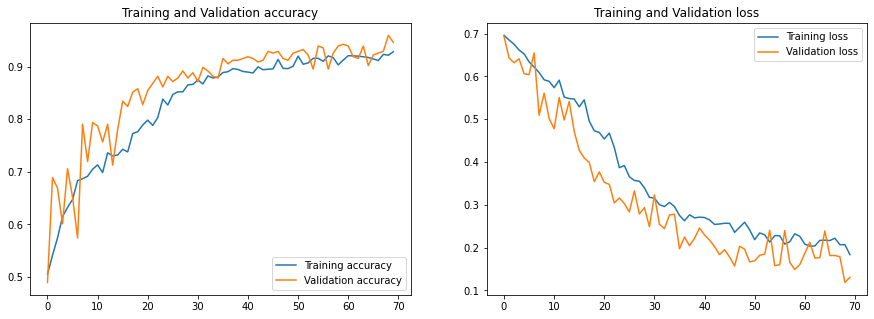

In [26]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

plt.show()

Beautiful!  
From these line plots we can confidently say a 100 epochs wasn't needed. Perhaps 75 should have sufficed.  
It's interesting how we can visualise how accuracy increases and loss decreases.  
  
  
  
### Some extracurricular testing
Let's play with the model...

We'll randomly select an image from _test_ds_; We'll plot this image then print it's actual label and predicted label.

Predicting this image...
Actual label: no_tumour
1/1 [==============================] - 0s 211ms/step
Predicted label: no_tumour


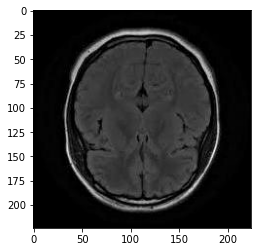

In [75]:
import numpy as np

# Gets the label names from the dataset object.
label_names = dataset.class_names

for images_batch, labels_batch in test_ds.take(1):
    image = images_batch[0].numpy().astype("uint8")
    label = labels_batch[0].numpy()
    
    print("Predicting this image...")
    plt.imshow(image)
    print(f"Actual label: {label_names[label]}")
    
    # Binary classification: less than 0.5 is [0] and greater than 0.5 is [1]
    predictions = model.predict(images_batch)
    print(f"Predicted label: {label_names[np.argmax(predictions[0])]}")

As always, we'll define a function that takes the image and returns the predicted label.

In [76]:
def classify(model, img):
    
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    
    # Create a batch.
    image_array = tf.expand_dims(image_array, 0)
    
    # Get prediction.
    prediction = model.predict(image_array)
    
    # Get label name
    predicted_label = label_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_label, confidence

Now, we can plot several images and get their predictions using the above function.

1/1 [==============================] - 0s 38ms/step


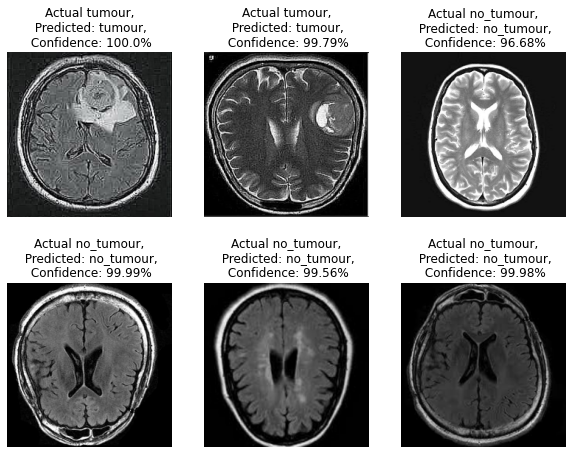

In [94]:
# Expand plot size.
plt.figure(figsize=(10, 12))

for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_label, confidence = classify(model, images[i].numpy())
        actual_label = label_names[labels[i]]
        
        plt.title(f"Actual {actual_label},\n Predicted: {predicted_label},\n Confidence: {confidence}%")
        plt.axis("off")

Perfect!  
Everything is working fine.  
Let's go ahead and save the model.

In [86]:
model_version = "multiclass_model"
model.save(f"C:/Users/ifunanyaScript/Everything/BrainTumour_DiagnosisApp/models/{model_version}")

In [95]:
# ifunanyaScript